# Drug Prescriber


## Drug Type Classification

This Jupyter notebook serves as a walkthrough for simple data exploration and contructing a classification model. It is by no means meant to be comprehensive. The methodology presented represents one of many possible approaches.

## Dataset

https://www.kaggle.com/prathamtripathi/drug-classification

## Motivation

Suppose you are the director of a hospital with a recent influx of patients that has led to increasingly hectic schedules for your staff. In order to maintain the highest standard of care for not only your patients but your staff, you are investigating methods to alleviate some work. After observing the hospital's activity for a period of time, you notice that many patients are coming in for similar health concerns and the vast majority of the prescribed medications are from a selection of 5 drugs. Having piqued your interest, you begin compiling and analyzing data from patients who were prescribed the aforementioned drugs. Following discussion with fellow physicians who draw from their years of experience, you identify biomarkers most relevant to the 5 drug prescriptions. You are now interested in constructing a classifier which can predict which drug should be prescribed given the relevant biomarker data you identified earlier. If the clasifier works well, patient hospital visits can be more streamlined with a physician at the end checking to ensure the prescribed medication is correct. You hope this will alleviate some pressure on your staff while maintaining the hospital's ability to treat patients as physicians would no longer need to see each patient one-by-one given their visit to the hospital involves similar symptoms and identical biomarkers. 


## Objective

Use the drug dataset to construct a classifier to predict the correct drug to prescribe.

Let's get started! First, we need to load the data from Kaggle and import the necessary libraries to help us work with and visualize the data.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

DATA_PATH = "/Users/jeffguo/PycharmProjects/DrugClassification/drug200.csv"
drug_data = pd.read_csv(DATA_PATH)

## Data Exploration 

Before we fit any models to the data, it is always a good idea to gain an understanding on what the data looks and what type of data types it encompasses. Some important questions to keep in mind are:

1) What sort of features (measurable quantities or qualitative attributes) are provided? --> This will be important later in selecting attributes (feature + its value) to train our classifer

2) Is the dataset complete? Are there missing values? --> This is important as missing values would either require locating the missing data, filling in the gaps in the data via imputation (ex. substituting the median of the feature values in the gaps), or dropping those data points

3) Which data types are encompassed in the dataset? --> Working with numerical (ex. integers and floats) will be different than categorical data (ex. sex: is the patient Male or Female?)

4) Does the data contain discrete values? Continuous values? A combination of both? --> The values a feature can take on will be important in feature selection for our regression model 

In [2]:
drug_data.head() # look at the first 5 entries of the dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


There are 6 features in the dataset given by each individual column. From just these 5 rows, it seems the dataset contains a combination of discrete (ex. BP) and continuous (Na_to_K) features. Let's take a further look at the data types of each feature.

In [3]:
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Lucky for us, it looks like the dataset is not missing any values! Way to go for being thorough in your patient data collection! We know this as there are 200 entries and all 6 features contain 200 data points. Let's take a closer look at the "Dtype" (data type). It looks like "Age" and "Na_to_K"are "int64" and "float64", respectively. The other four features, "Sex", "BP", "Cholesterol", and "Drug" are "object". In principal, "object" can be any Python object but since the dataset was loaded using the pandas "read_csv" method, it must be a text object. Looking back at the top 5 entries displayed above, we can see that these are indeed text objects (ex. BP has "High, "Low", "Normal" values). We should have an idea on which features are discrete/continuous now but just to be sure, let's take a look at the possible values for each feature.

In [4]:
drug_data["Age"].value_counts() # quick glance shows a wide range of integer ages, discrete variable

# Note: using value_counts() may not always be a good idea especially if the dataset is large.
#       The output would be difficult to read and a histogram would be more suitable (we do this later)

47    8
49    7
23    7
28    7
39    6
32    6
50    5
22    5
58    5
37    5
60    5
43    4
42    4
41    4
74    4
51    4
34    4
31    4
26    4
24    4
20    4
36    4
45    4
72    4
56    4
57    4
68    4
67    4
65    4
61    4
64    3
35    3
16    3
18    3
70    3
69    3
53    3
15    3
40    3
38    3
59    3
55    2
48    2
19    2
46    2
73    2
52    2
66    2
29    2
62    2
33    1
25    1
21    1
30    1
54    1
17    1
63    1
Name: Age, dtype: int64

In [5]:
drug_data["Sex"].value_counts() # discrete, 2 values: "M" or "F"

M    104
F     96
Name: Sex, dtype: int64

In [6]:
drug_data["BP"].value_counts()     
# instead of a continuous variable as one may be used to (120/80 mmHg) 
# for systolic/diastolic pressure, it is actually discrete, with "High", "Low", and "Normal" values

HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

In [7]:
drug_data["Cholesterol"].value_counts()      
# again, instead of a continuous variable as one may have expected, it is discrete, featuring "High" and "Normal"

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

In [8]:
drug_data["Na_to_K"].value_counts() # looks like a continous variable

12.006    2
18.295    2
9.945     1
9.475     1
20.013    1
         ..
13.884    1
7.285     1
22.905    1
7.340     1
8.750     1
Name: Na_to_K, Length: 198, dtype: int64

In [9]:
drug_data["Drug"].value_counts() # discrete, 5 types of drugs: A, B, C, X, Y

DrugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: Drug, dtype: int64

We now have an understanding of what the attributes (feature + its value) look like and whether they are discrete or continuous variables. For the continuous variables ("Age" and "Na_to_K"), it will be useful visualize the distribution.

Text(0, 0.5, 'Total Count')

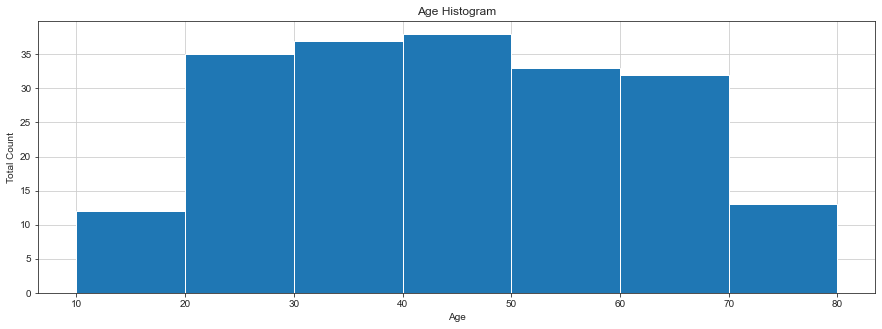

In [10]:
sb.set_style("ticks")
drug_data["Age"].hist(bins=[10,20,30,40,50,60,70,80], figsize=(15,5))
plt.title("Age Histogram")
plt.xlabel("Age")
plt.ylabel("Total Count")

Text(0, 0.5, 'Total Count')

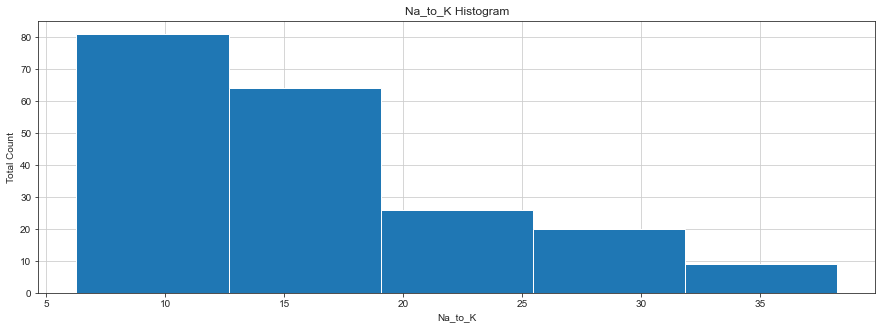

In [11]:
drug_data["Na_to_K"].hist(bins=5, figsize=(15,5))
plt.title("Na_to_K Histogram")
plt.xlabel("Na_to_K")
plt.ylabel("Total Count")

"Age" and "Na_to_K" are indeed continuous variables and beyond the actual values that the features take on, the distributions can also offer valuable insights. For instance, notice in the "Na_to_K" histogram that although the values range from ~ [6-38], the distribution of values is right-skewed (lower values are more populated). In general, as "Na_to_K" increases, the population of the histogram interval bins decrease (ex. the ~35 bin is much shorter than the ~10 bin). When training our classifier, it may be important to take this into account especially if these scarce values have significant impact on the target feature. In which case, the training data should incorporates these values to ensure the classifier has seen a representative subset of the data. We will follow-up on this later when we train our classifer.

## Feature Selection

Now that we have a basic understanding of the dataset we are working with, let's turn our attention to the target feature we are predicting: "Drug". How should we go about selecting features to train our classifier? Should we use all the features available? A good way to decide is to probe how the features affect drug type prescriptions. Are there certain threshold values that lead to drug X prescribed over drug Y? What are the combinations of feature (ex. "Age" and "Na_to_K") values, if any, that lead to drug Z to be prescribed over drug W? These are all questions we can investigate by plotting each feature against "Drug". 

* Note that drugs X, Y, Z, W are arbitrary identifiers for the purpose of posing the questions above

Text(0.5, 1.0, 'Age vs. Drug')

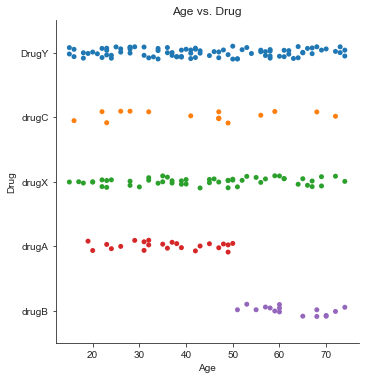

In [12]:
# make the displayed plots bigger
plt.rcParams["figure.figsize"] = (10,10)
sb.catplot(x="Age", y="Drug", data=drug_data)
plt.title("Age vs. Drug")

Interesting! Drugs Y, C, and X seem to be prescribed for all ages in the dataset while A and B have clear age cut-offs. It looks like drug A is precribed for ages ~ [20-50] while B is prescribed for ages 
~ [51-75]. Our classifier should take this into account.

Text(0, 0.5, 'Total Counts')

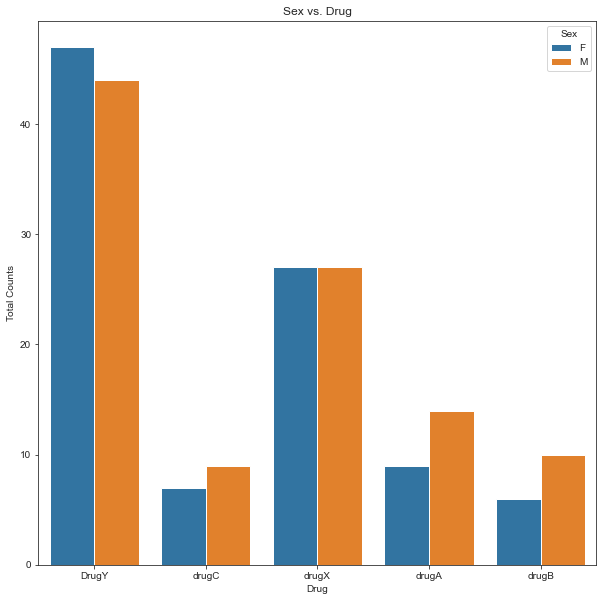

In [13]:
sb.countplot(x="Drug", hue="Sex", data=drug_data)
plt.title("Sex vs. Drug")
plt.xlabel("Drug")
plt.ylabel("Total Counts")

There doesn't seem to be a drug that is prescribed exclusively for each sex. In fact, the distributions look quite similar, suggesting that "Sex" is not very important in determining the drug type.

Text(0, 0.5, 'Total Counts')

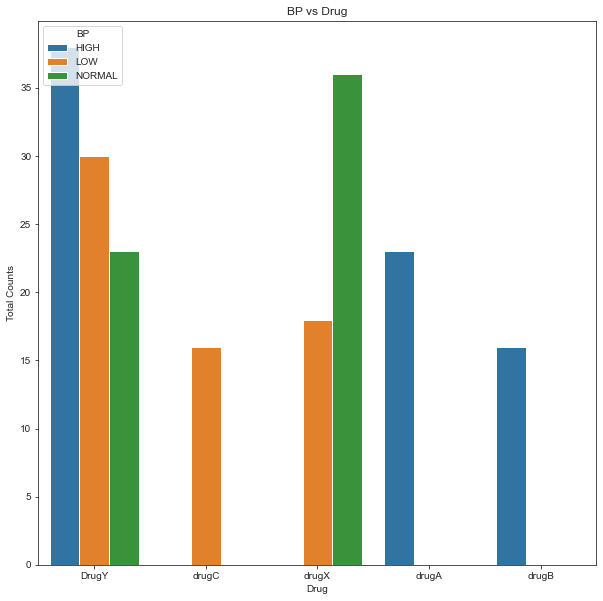

In [14]:
sb.countplot(x="Drug", hue="BP", data=drug_data)
plt.title("BP vs Drug")
plt.xlabel("Drug")
plt.ylabel("Total Counts")

Insightful! "BP" levels affect which drug type is prescribed. "High" BP patients were prescribed drugs B, A, and Y. "Low" BP patients were prescribed drugs X, C, and Y. "Normal" BP patients were prescribed drugs X and Y. Furthermore, notice some drugs were prescribed given multiple BP levels (ex. drug Y: "High", "Low", and "Normal"). In contrast, some drugs were prescribed exclusively given a specific BP level (ex. drug C: "Low"). Taken together, these observations convey that "BP" is informative but is not deterministic in deciding which drug type to prescribe. Our classifier should definitely take "BP" into account.

Text(0, 0.5, 'Total Counts')

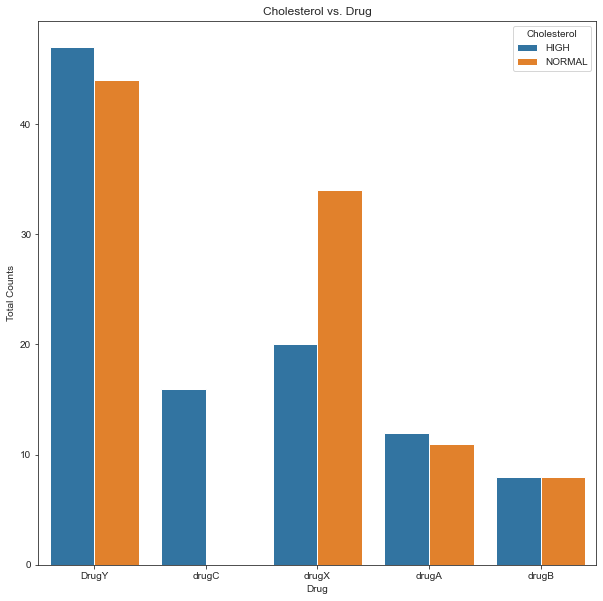

In [15]:
sb.countplot(x="Drug", hue="Cholesterol", data=drug_data)
plt.title("Cholesterol vs. Drug")
plt.xlabel("Drug")
plt.ylabel("Total Counts")

It looks like most drugs are prescribed to patients with both cholesterol levels. The only exception is drug C which is exclusively prescribed to patients with "High" cholesterol. Our classifier should take this into account.

Text(0.5, 1.0, 'Na_to_K vs. Drug')

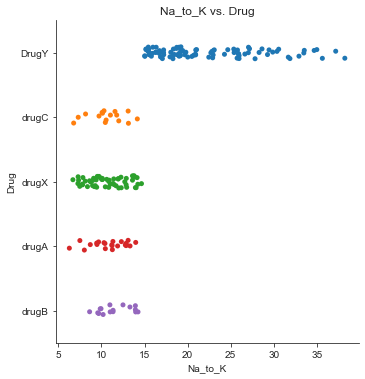

In [16]:
sb.catplot(x="Na_to_K", y="Drug", data=drug_data)
plt.title("Na_to_K vs. Drug")

Insightful again! It looks like drugs C, X, A, and B are prescribed for patients with "Na_to_K" values below 15 while drug Y is exclusively precribed for values above. Taking a bird's eye view of all the feature plots, we begin to see combinations emerge which seem to determine which drug to prescribe. For instance, notice in all the previous feature plots, drug Y was prescribed for all values (ex. "all ages"and "High", "Low", and "Normal" BP). However, in the <"Na_to_K" plot above, only patients with values greater than 15 are prescribed drug Y. Therefore, "Na_to_K" measurements are crucial in deciding whether to prescribe drug Y or not.


Let's summarize our findings from the above feature plots:

1) "Age"
* Drugs Y, C, and X all ages
* Drug A ages ~ [20-50]
* Drug B ages ~ [51-75]

2) "Sex"
* All drug prescribed for both sexes

3) "BP"
* Drug X "Low" and "Normal" BP
* Drug C only "Low" BP
* Drug B and A only "High" BP
* Drug Y all BP

4) "Cholesterol"
* Drugs B, A, X, and Y all cholesterol 
* Drug C only "High" cholesterol

5) "Na_to_K"

* Drugs C, X, A, and B Na_to_K ~ [6-15]
* Drug Y greater than 15

From these observations, we have also identified the features we should include in our classifier:
"Age", "BP", "Cholesterol", and "Na_to_K".

## Feature Processing: Handling Categorical Data

Notice some features contain categorical text values (ex. "BP" with values "High", "Low", and "Normal"). In general, machine learning algorithms are only compatible with numerical data. It is not intrinsically bad to have categorical data especially when they are informative within the context of the dataset (ex. "BP"). That being said, categorical data often requires some processing to change it into numerical representation through encoding. Encoding uses numerical representations to map categorical values (ex. "0" can encode for "High" BP). In our case, we will use ordinal encoding for the training features which is intended for categories whose values follow a series ranked progression. For instance, "Cholesterol" values follow the ranked progression from "High" to "Normal". Next, we will use label encoding for our target feature (also known as label), "Drug". 

In [17]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# ordinal encoder used for training features
ordinal_enc = OrdinalEncoder()
# label encoder used for target label ("Drug")
label_enc = LabelEncoder()
# extract the categorical features
ordinal_cat = drug_data[["BP", "Cholesterol"]]
label_cat = drug_data["Drug"]
# verify the attributes (features + its values) are as expected (only show first 5 rows)
print(ordinal_cat[:5])
print(label_cat[:5])
# encode the attributes
ordinal_drug_attributes = ordinal_enc.fit_transform(ordinal_cat)
label_drug_attributes = label_enc.fit_transform(label_cat).reshape(-1,1)
# verify encoding changed the categorical text to numerical representation (only show first 5 rows)
print(ordinal_drug_attributes[:5])
print(label_drug_attributes[:5])
# display the encoding legend 
print(ordinal_enc.categories_)
print(label_enc.classes_)


       BP Cholesterol
0    HIGH        HIGH
1     LOW        HIGH
2     LOW        HIGH
3  NORMAL        HIGH
4     LOW        HIGH
0    DrugY
1    drugC
2    drugC
3    drugX
4    DrugY
Name: Drug, dtype: object
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [2. 0.]
 [1. 0.]]
[[0]
 [3]
 [3]
 [4]
 [0]]
[array(['HIGH', 'LOW', 'NORMAL'], dtype=object), array(['HIGH', 'NORMAL'], dtype=object)]
['DrugY' 'drugA' 'drugB' 'drugC' 'drugX']


Following encoding, "BP", "Cholesterol", and "Drug" are now in numerical format. Referring to the displayed encoding legends, we can see the following mappings:
1) "BP"
* 0 --> "High"
* 1 --> "Low",
* 2 --> "Normal"

2) "Cholesterol"
* 0 --> "High"
* 1 --> "Normal"

3) "Drug"
* 0 --> "DrugY"
* 1 --> "DrugA"
* 2 --> "DrugB"
* 3 --> "DrugC"
* 4 --> "DrugX"

Let's now incorporate these encoded attributes into an updated DataFrame. Don't forget we need to also include the numerical attributes, "Age" and "Na_to_K".

In [18]:
# take only the numerical attributes here
numerical_drug_attributes_df = drug_data.drop(["BP", "Cholesterol", "Drug", "Sex"], axis=1)
# transform the ordinal categorical attributes numpy array to a DataFrame for concatenation
ordinal_drug_attributes_df = pd.DataFrame(ordinal_drug_attributes, columns=["BP", "Cholesterol"])
# transform the label categorical attribute numpy array to a DataFrame for concatenation
label_drug_attributes_df = pd.DataFrame(label_drug_attributes, columns=["Drug"])
# concatenate the numerical and encoded categorical DataFrames
drug_data_prepped = pd.concat([numerical_drug_attributes_df, ordinal_drug_attributes_df, 
                               label_drug_attributes_df], axis=1)
print(drug_data_prepped)



     Age  Na_to_K   BP  Cholesterol  Drug
0     23   25.355  0.0          0.0     0
1     47   13.093  1.0          0.0     3
2     47   10.114  1.0          0.0     3
3     28    7.798  2.0          0.0     4
4     61   18.043  1.0          0.0     0
..   ...      ...  ...          ...   ...
195   56   11.567  1.0          0.0     3
196   16   12.006  1.0          0.0     3
197   52    9.894  2.0          0.0     4
198   23   14.020  2.0          1.0     4
199   40   11.349  1.0          1.0     4

[200 rows x 5 columns]


The data is now ready for application! As a final note, <font color='orange'>"Sex"</font> is not included in the final prepared dataset because previous feature plotting illustrate its negligible effect on drug types.

## Train/Test Set Splitting: Handling Sampling Bias

We are now almost ready to split our data into train/test sets to train our classifier and evaluate its performance. However, it is important to be cognizant of potential sampling bias. Recall in the "Na_to_K" histogram the distribution is right-skewed (shown in the below cell block again). 

<AxesSubplot:>

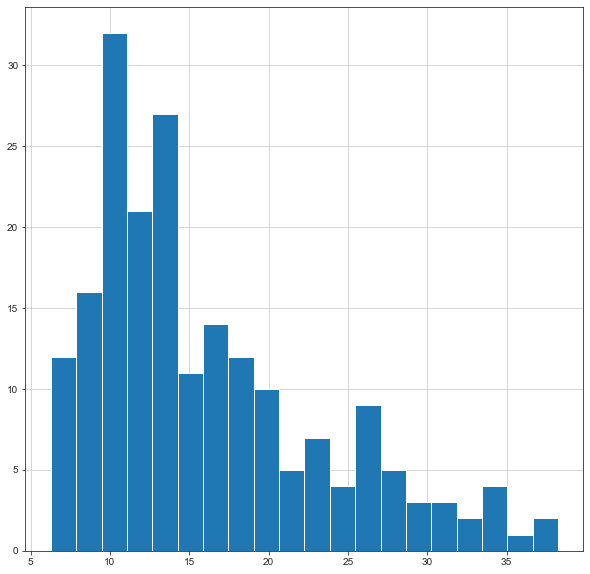

In [19]:
drug_data_prepped["Na_to_K"].hist(bins=20, figsize=(10,10))

When splitting our data, both training/test sets should include the scarce values (ex. >30) so that they are representative of the overall dataset. Otherwise, we run the risk of our classifier not having seen these points yet and having difficulty determining the drug type and/or conversely not having test data to evaluate our classifier thoroughly. One method to handle sampling bias is to use stratified splitting as opposed to normal splitting.

Let's get started with stratified splitting! First, divide the "Na_to_K" into subgroups (strata) and sample the correct proportion of data points from each subgroup (stratum).

Text(0, 0.5, 'Total Counts')

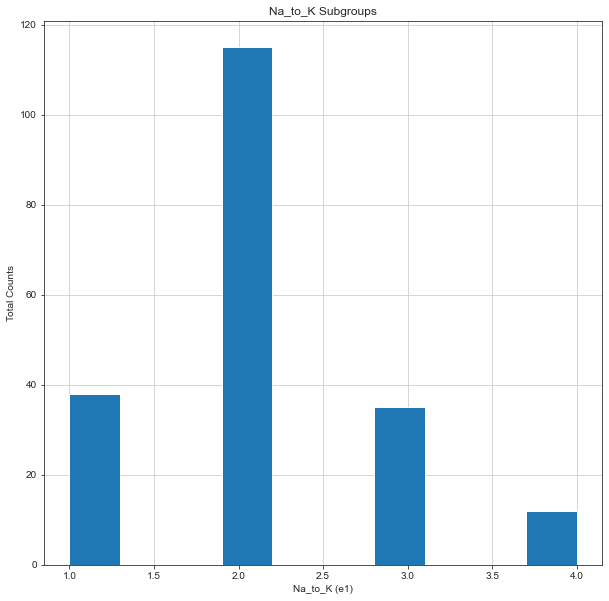

In [20]:
drug_data_prepped["Na_to_K_subgroups"] = pd.cut(drug_data_prepped["Na_to_K"], 
                                                bins=[0,10,20,30,np.inf], 
                                                labels=[1,2,3,4])

drug_data_prepped["Na_to_K_subgroups"].hist()
plt.title("Na_to_K Subgroups")
plt.xlabel("Na_to_K (e1)")
plt.ylabel("Total Counts")

As expected, the most populated bin is [10-20), consistent with the "Na_to_K" histogram earlier. Let's now take a stratified split of the overall dataset to generate our test/train sets.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

# random_state=42 for reproducibility (otherwise, running this block successive times yields different results)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_split.split(drug_data_prepped, drug_data_prepped["Na_to_K_subgroups"]):
    stratified_train_set = drug_data_prepped.loc[train_index] 
    stratified_test_set = drug_data_prepped.loc[test_index]
    
# train/test 80/20 split (160/40 entries)
print(len(stratified_train_set)) # 160
print(stratified_train_set)
print(len(stratified_test_set)) # 40
print(stratified_test_set)

160
     Age  Na_to_K   BP  Cholesterol  Drug Na_to_K_subgroups
101   45   12.854  0.0          0.0     1                 2
102   28   13.127  1.0          0.0     3                 2
85    59   13.935  0.0          0.0     2                 2
105   37    8.968  1.0          1.0     4                 1
94    56   15.015  1.0          0.0     0                 2
..   ...      ...  ...          ...   ...               ...
171   45   10.017  1.0          1.0     4                 2
115   51   18.295  0.0          0.0     0                 2
168   51   23.003  1.0          1.0     0                 3
193   72    6.769  1.0          0.0     3                 1
192   72   16.310  1.0          0.0     0                 2

[160 rows x 6 columns]
40
     Age  Na_to_K   BP  Cholesterol  Drug Na_to_K_subgroups
116   67    9.514  2.0          1.0     4                 1
126   66   16.347  0.0          0.0     0                 2
6     49   16.275  2.0          0.0     0                 2
22    47 

After shuffling and stratified splitting, we now have our train/test sets. The print statements in the previous block confirm we have generated an 80/20 split. 

Our choice for stratified splitting was to reduce sampling bias but how can we be sure that we have achieved this? We could obtain the actual proportions of the "Na_to_K_subgroups" feature in the context of the overall dataset. Doing so will allow us to see what proportions of the overall dataset populates each bin we created above. Subsequently, comparison of these proportions with those from the stratified test set and a test set generated from random splitting will allow us to quantitatively observe sampling improvements, if any, from the stratified approach over random sampling. 

In [22]:
from sklearn.model_selection import train_test_split

# generate the train/test sets via random splitting to compare
# random_state=42 for reproducibility
random_train_set, random_test_set = train_test_split(drug_data_prepped, test_size=0.2, random_state=42)

# construct a DataFrame to compare the test set proportions
comparison_df = pd.DataFrame({"Overall Data Na_to_K_subgroups Proportions": drug_data_prepped["Na_to_K_subgroups"].value_counts() / len(drug_data),
                              "Random Splitting Na_to_K_subgroups Proportions": random_test_set["Na_to_K_subgroups"].value_counts() / len(random_test_set),
                              "Stratified Splitting Na_to_K_subgroups Proportions": stratified_test_set["Na_to_K_subgroups"].value_counts() / len(stratified_test_set)})
print(comparison_df)


   Overall Data Na_to_K_subgroups Proportions  \
1                                       0.190   
2                                       0.575   
3                                       0.175   
4                                       0.060   

   Random Splitting Na_to_K_subgroups Proportions  \
1                                           0.200   
2                                           0.575   
3                                           0.200   
4                                           0.025   

   Stratified Splitting Na_to_K_subgroups Proportions  
1                                              0.200   
2                                              0.575   
3                                              0.175   
4                                              0.050   


The value_counts() method returns a pandas series of unique value counts. Dividing by the length of the dataset returns the proportion of values populating each bin that we defined earlier. The comparison DataFrame displays the proportions of all bins for the overall dataset and the test sets via stratified and random splitting. Notice the stratified bin proportions are much closer to the overall data proportions. Notably, the scarce "Na_to_K" values we are most interested in, are located in bins 3 and 4. Correspondingly, the stratified proportions are much closer to the true overall dataset than the random proportions and therefore stratified sampling successfuly reduces the sampling bias.

Having convinced ourselves that stratified splitting yields more suitable train/test sets for our drug classifier, let's remove the "Na_to_K_subgroups" feature and return the stratified train/test sets to their unmodified state. We do this because "Na_to_K_subgroups" is not a feature we require for training and was strictly added to demonstrate sampling bias reduction.

In [23]:
for data_set in (stratified_train_set, stratified_test_set):
    data_set.drop("Na_to_K_subgroups", axis=1, inplace=True)

## Drug Classifier Part 1: Model Training 

One last thing to do before training our models is to split the stratified train/test sets into "X" and "y" subsets, denoting our training features ("Age", "BP", "Cholesterol", and "Na_to_K") and target feature ("Drug"), respectively.

In [24]:
# X subsets keep all training features, "Age", "Na_to_K", "BP", and "Cholesterol"
X_train = stratified_train_set 
X_test = stratified_test_set

# y subsets keep only the target feature, "Drug"
y_train = stratified_train_set.drop(["Age", "Na_to_K", "BP", "Cholesterol"], axis=1) 
y_test = stratified_test_set.drop(["Age", "Na_to_K", "BP", "Cholesterol"], axis=1) 

# drop the target feature, "Drug" from the X subsets
X_train.drop("Drug", axis=1, inplace=True)
X_test.drop("Drug", axis=1, inplace=True)

print(X_train) # train set training features
print(X_test) # test set training features 
print(y_train) # train set target feature
print(y_test) # test set target feature 

     Age  Na_to_K   BP  Cholesterol
101   45   12.854  0.0          0.0
102   28   13.127  1.0          0.0
85    59   13.935  0.0          0.0
105   37    8.968  1.0          1.0
94    56   15.015  1.0          0.0
..   ...      ...  ...          ...
171   45   10.017  1.0          1.0
115   51   18.295  0.0          0.0
168   51   23.003  1.0          1.0
193   72    6.769  1.0          0.0
192   72   16.310  1.0          0.0

[160 rows x 4 columns]
     Age  Na_to_K   BP  Cholesterol
116   67    9.514  2.0          1.0
126   66   16.347  0.0          0.0
6     49   16.275  2.0          0.0
22    47   30.568  1.0          1.0
146   37   12.006  1.0          1.0
37    39   13.938  1.0          1.0
110   50    7.490  0.0          0.0
141   64   25.741  1.0          1.0
160   30   10.443  2.0          0.0
120   28   27.064  2.0          0.0
73    41   22.905  2.0          1.0
65    68   27.050  2.0          1.0
112   35    9.170  1.0          1.0
66    29   12.856  0.0          0.0
56  

Let's start with a linear Support Vector Machine (SVM) classifier optimized via Stochastic Gradient Descent (SGD).

0.5


Text(0, 0.5, 'Actual Prescribed Drug')

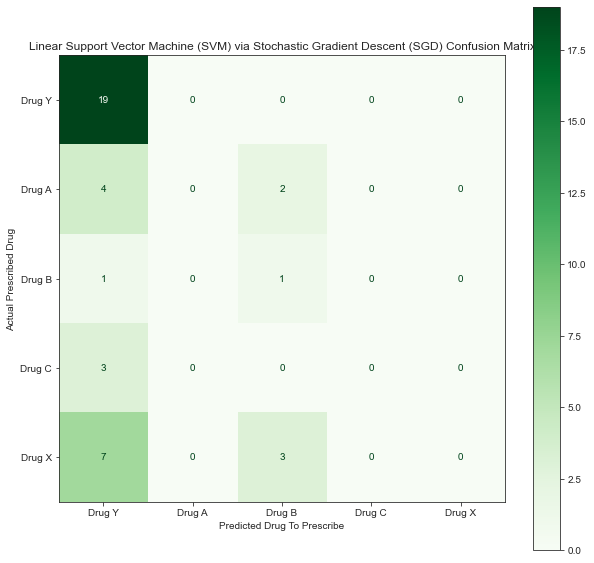

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_confusion_matrix

# random_state=42 for reproducibility
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, np.asarray(y_train).ravel())
sgd.predict(X_test)
# print the proportion of correct predictions
print(sgd.score(X_test, y_test))

# generate a confusion matrix to visualize the prediction performance
# display_labels based on previous ordinal encoding where 0 maps to "Drug Y", 1 maps to "Drug A", etc.
plot_confusion_matrix(sgd, X_test, y_test, cmap="Greens",
                      display_labels=np.asarray(["Drug Y", "Drug A", "Drug B", "Drug C", "Drug X"]))
plt.title("Linear Support Vector Machine (SVM) via Stochastic Gradient Descent (SGD) Confusion Matrix")
plt.xlabel("Predicted Drug To Prescribe")
plt.ylabel("Actual Prescribed Drug")

Following training of a linear SVM classifier, the model is only able to predict the correct drug to prescribe 50% of the time! Let's investigate where the classifier goes wrong. A good method in evaluating classifiers is the use of confusion matrices which compares the predicted values to the actual values. A perfect classifer would only have values in the main diagonal of the matrix, signifying that every prediction is correct. Referring to the linear SVM confusion matrix, we see that this is unfortunately not the case. In fact, notice the classifer predicts Drug Y to prescribe an overwhelming number of times! If we sum each column up, we can see that the classifer predicts Drug Y 34/40 times and Drug B 6/40 times. The classifier did not predict Drugs B, C, and X even once! In general, poor model performance can be attributed to poor data preparation, poor feature selection, an insufficient model, or a combination of these. As a first step in addressing our model's limitations, confusion matrices can often point us in the right direction. Notice again that Drug Y is predicted 34/40 times. Could there be any merit to this behaviour? Recall the insights we gained during feature plotting and specifically the criteria where Drug Y is prescribed:

1) "Age"
* Drug Y prescribed for all ages

2) "Sex"
* Drug Y prescribed for both sexes

3) "BP"
* Drug Y prescribed for all BP

4) "Cholesterol"
* Drug Y prescribed for all cholesterol


5) "Na_to_K"
* Drug Y prescribed for values greater than 15

In most cases, Drug Y is prescribed for all values of the features! The only exception is for "Na_to_K" where Drug Y is prescribed for values greater than 15. Perhaps our model was not able to learn this behaviour and we could instead steer its learning to encompass this. In principal, as long as the model learns to prescribe Drug Y only when "Na_to_K" > 15, the performance should improve! We will discuss this further in the next section.

For now, let's try a K-Nearest Neighbours (KNN) classifier and see if its performance is better.

0.725


Text(0, 0.5, 'Actual Prescribed Drug')

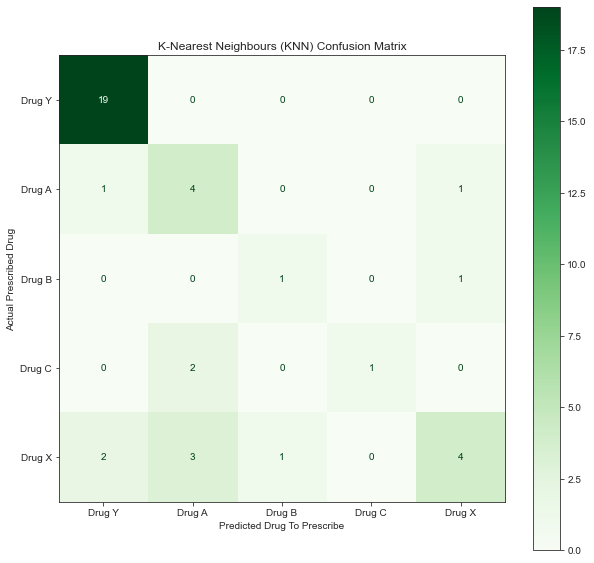

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, np.asarray(y_train).ravel())
knn.predict(X_test)
# print the proportion of correct predictions
print(knn.score(X_test, y_test))

# generate a confusion matrix to visualize the prediction performance
# display_labels based on previous ordinal encoding where 0 maps to "Drug Y", 1 maps to "Drug A", etc.
plot_confusion_matrix(knn, X_test, y_test, cmap="Greens",
                      display_labels=np.asarray(["Drug Y", "Drug A", "Drug B", "Drug C", "Drug X"]))
plt.title("K-Nearest Neighbours (KNN) Confusion Matrix")
plt.xlabel("Predicted Drug To Prescribe")
plt.ylabel("Actual Prescribed Drug")

Performance improves with the KNN classifier - 72.5% of the predictions are correct! Importantly, this classifier much better predicts Drug Y (only 3 incorrect predictions compared to 15 for the linear SVM classifier). In addition, unlike the linear SVM classifier, there are predictions for Drug A, C, and X, regardless of whether they are correct. It is now perhaps hard to believe that the linear SVM classifier only predicted 2 drugs (Y and B)! These observations clearly demonstrate that the KNN classifier is better suited for our purpose and its performance score suggests that it better learns the drug prescription behaviour than the linear SVM classifier. That being said, a useful classifier and certainly one that will make a sizable impact in alleviating stress at the hospital would require even better performance. Let's next try a Random Forest classifier.

0.95


Text(0, 0.5, 'Actual Prescribed Drug')

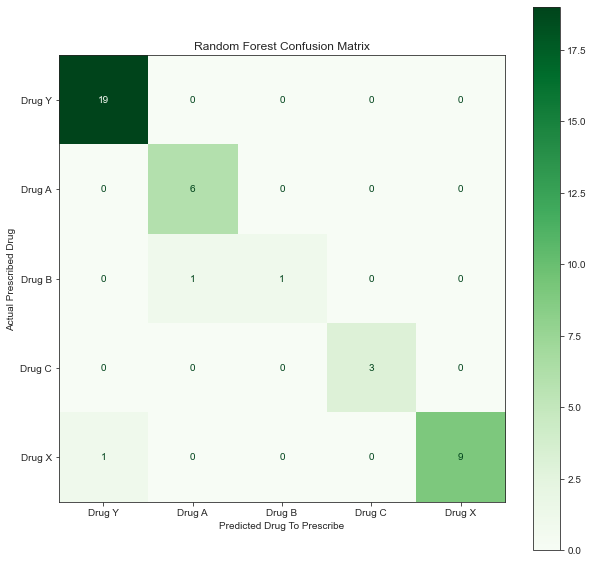

In [27]:
from sklearn.ensemble import RandomForestClassifier

# random_state=42 for reproducibility
rand_forest = RandomForestClassifier(random_state=42)
rand_forest.fit(X_train, np.asarray(y_train).ravel())
rand_forest.predict(X_test)
# print the proportion of correct predictions
print(rand_forest.score(X_test, y_test))

# generate a confusion matrix to visualize the prediction performance
# display_labels based on previous ordinal encoding where 0 maps to "Drug Y", 1 maps to "Drug A", etc
plot_confusion_matrix(rand_forest, X_test, y_test, cmap="Greens",
                      display_labels=np.asarray(["Drug Y", "Drug A", "Drug B", "Drug C", "Drug X"]))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Drug To Prescribe")
plt.ylabel("Actual Prescribed Drug")

The Random Forest classifier looks great! It correctly predicts the drug 95% of the time! Notice now that the majority of values in the confusion matrix are along the main diagonal, which again denote correct predictions. There are only 2/40 incorrect predictions (Drugs Y and A). This classifier should be able to help alleviate some pressure at the hospital! 

While the performance of this classifier may be satisfactory for our purpose, we should always strive to improve our models. This is especially the case if the performance metric was closer to say, 0.8 (80%). Let's next take a look at methods to improve our models.

## Drug Classifier Part 2: Model Improvements

Recall the SGD classifier made many incorrect Drug Y predictions. Looking back at the feature plots, we pinpoint that the defining attribute for Drug Y predictions is "Na_to_K" > 15. Could we steer our classifiers' learning to encompass this?We could update the "Na_to_K" feature to have binary values: 0 if "Na_to_K" < 15 and 1 if "Na_to_K" rather than being the continuous variable it is now.

In [28]:
# define a function to return 0 if Na_to_K < 15 and 1 if Na_to_K > 15
def binary_Na_to_K(value):
    
    if value < 15:
        return 0
    if value >= 15:
        return 1

# the Na_to_K feature is part of the training features found in X_train and X_test
X_train["Na_to_K"] = X_train["Na_to_K"].apply(binary_Na_to_K)
X_test["Na_to_K"] = X_test["Na_to_K"].apply(binary_Na_to_K)

# display the updated DataFrames to verify the modifications are as expected
print(X_train)
print(X_test)

     Age  Na_to_K   BP  Cholesterol
101   45        0  0.0          0.0
102   28        0  1.0          0.0
85    59        0  0.0          0.0
105   37        0  1.0          1.0
94    56        1  1.0          0.0
..   ...      ...  ...          ...
171   45        0  1.0          1.0
115   51        1  0.0          0.0
168   51        1  1.0          1.0
193   72        0  1.0          0.0
192   72        1  1.0          0.0

[160 rows x 4 columns]
     Age  Na_to_K   BP  Cholesterol
116   67        0  2.0          1.0
126   66        1  0.0          0.0
6     49        1  2.0          0.0
22    47        1  1.0          1.0
146   37        0  1.0          1.0
37    39        0  1.0          1.0
110   50        0  0.0          0.0
141   64        1  1.0          1.0
160   30        0  2.0          0.0
120   28        1  2.0          0.0
73    41        1  2.0          1.0
65    68        1  2.0          1.0
112   35        0  1.0          1.0
66    29        0  0.0          0.0
56  

"Na_to_K" is now binarized as we intended. Let's try training the classifiers again!

0.5


Text(0, 0.5, 'Actual Prescribed Drug')

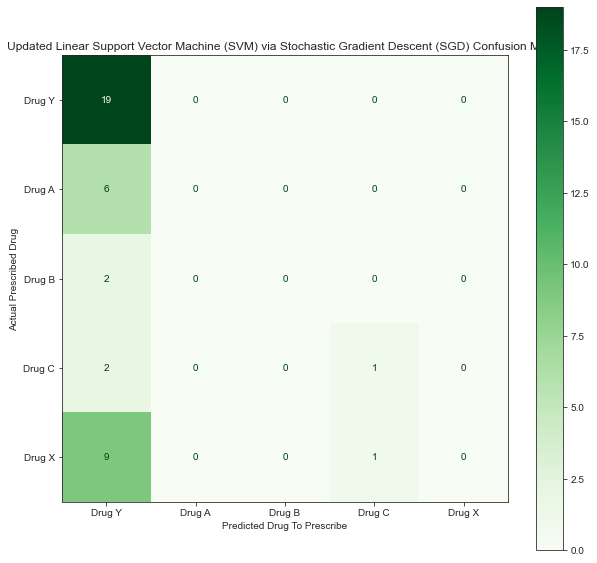

In [29]:
# random_state=42 for reproducibility
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, np.asarray(y_train).ravel())
sgd.predict(X_test)
# print the proportion of correct predictions
print(sgd.score(X_test, y_test))

# generate a confusion matrix to visualize the prediction performance
# display_labels based on previous ordinal encoding where 0 maps to "Drug Y", 1 maps to "Drug A", etc.
plot_confusion_matrix(sgd, X_test, y_test, cmap="Greens",
                      display_labels=np.asarray(["Drug Y", "Drug A", "Drug B", "Drug C", "Drug X"]))
plt.title("Updated Linear Support Vector Machine (SVM) via Stochastic Gradient Descent (SGD) Confusion Matrix")
plt.xlabel("Predicted Drug To Prescribe")
plt.ylabel("Actual Prescribed Drug")

Unfortunately, the linear SVM classifier did not improve! It is still predicting Drug Y the vast majority of the time. Let's see the changes to the KNN classifer.

0.575


Text(0, 0.5, 'Actual Prescribed Drug')

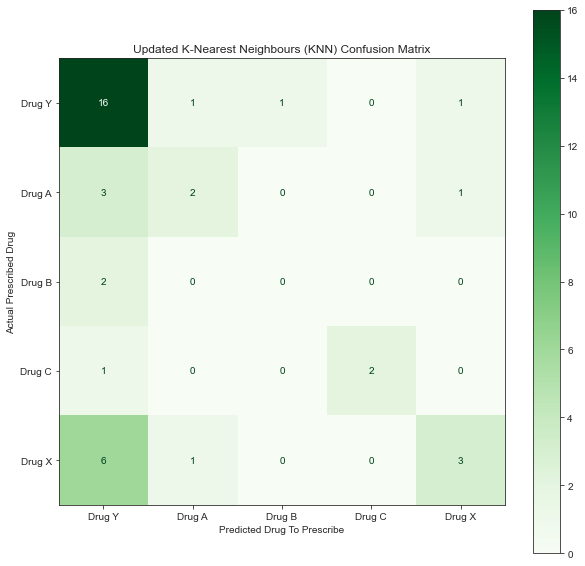

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, np.asarray(y_train).ravel())
knn.predict(X_test)
# print the proportion of correct predictions
print(knn.score(X_test, y_test))

# generate a confusion matrix to visualize the prediction performance
# display_labels based on previous ordinal encoding where 0 maps to "Drug Y", 1 maps to "Drug A", etc.
plot_confusion_matrix(knn, X_test, y_test, cmap="Greens",
                      display_labels=np.asarray(["Drug Y", "Drug A", "Drug B", "Drug C", "Drug X"]))
plt.title("Updated K-Nearest Neighbours (KNN) Confusion Matrix")
plt.xlabel("Predicted Drug To Prescribe")
plt.ylabel("Actual Prescribed Drug")

The KNN classifier actually got worse! The performance score dropped from 0.725 to 0.575. The binarized "Na_to_K" feature seems to be detrimental to our classifiers' performance! Let's finally check the Random Forest classifier.

0.975


Text(0, 0.5, 'Actual Prescribed Drug')

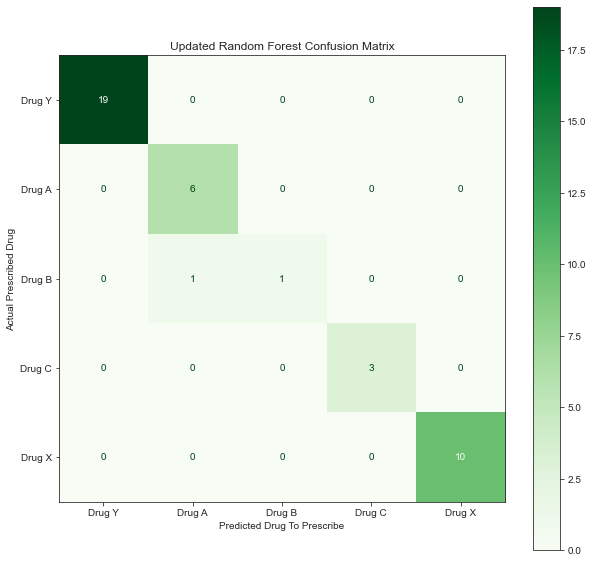

In [31]:
# random_state=42 for reproducibility
rand_forest = RandomForestClassifier(random_state=42)
rand_forest.fit(X_train, np.asarray(y_train).ravel())
rand_forest.predict(X_test)
# print the proportion of correct predictions
print(rand_forest.score(X_test, y_test))

# generate a confusion matrix to visualize the prediction performance
# display_labels based on previous ordinal encoding where 0 maps to "Drug Y", 1 maps to "Drug A", etc
plot_confusion_matrix(rand_forest, X_test, y_test, cmap="Greens",
                      display_labels=np.asarray(["Drug Y", "Drug A", "Drug B", "Drug C", "Drug X"]))
plt.title("Updated Random Forest Confusion Matrix")
plt.xlabel("Predicted Drug To Prescribe")
plt.ylabel("Actual Prescribed Drug")

The Random Forest classifier improved! The performance score increased from 0.95 to 0.975. Notably, all Drug Y predictions are correct now. Although previously the classifier only made 1 incorrect Drug Y prediction, the performance improvement suggests that it was able to learn the Drug Y prescription behaviour. Based on all the classifier results, we clearly observe that Random Forest performs the best and we thus choose this as our working model. At this point, a typical next step is to optimize or fine-tune the hyperparameters of our model. The so called hyperparameters are intrinsic to the model and affect how it learns from the training features. It is dependent on the specific application and therefore there is no single setting that always works best and is therefore determined via trial-and-error. 

In our Random Forest model, one hyperparameter we could tune is the number of trees used. A follow-up question is, given seemingly unlimited possibiltiies, how does one decide the number of trees to try? Thankfully, we can use GridSearchCV which can try different possibilities for us. As we are in control of this process, we also control how much computing power we want to allocate to the task.  As the model must be trained to assess each set of hyperparameters, we can imagine this could quickly get out of hand! For instance, trying 1000 possibiltiies may not be computationally feasible or necessary (ex. your classifier already performs well prior to hyperparameter fine-tuning).  Let's now use GridSearchCV to fine-tune our Random Forest classifier.

In [32]:
from sklearn.model_selection import GridSearchCV

# "n_estimators" denotes the number of trees to try, "max_features" denotes how many training features to use
param_grid = [{"n_estimators": [1,10,20,30,40,50,60,70,80,90,100],
               "max_features": [2,3,4]}]

random_forest_gscv = GridSearchCV(rand_forest, param_grid=param_grid, cv=5)
random_forest_gscv.fit(X_train, np.asarray(y_train).ravel())
random_forest_gscv.predict(X_test)

# display the best hyperparameters from the combinations tried
print(random_forest_gscv.best_params_)
# display the optimized hyperparameters score
print(random_forest_gscv.score(X_test, y_test))

{'max_features': 3, 'n_estimators': 20}
0.975


In the code block, we tried 1, 10, 20, etc. number of trees (10 different possibilities) and for each, we tried fitting a maximum of 2,3,4 training features (ex. "Age" and "BP"). Therefore, our Random Forest classifier was trained a total of 33 times! We then determined from the combinations tried, that the optimal hyperparameters are 20 trees and 3 training features. Although the score didn't improve (to be fair, it was already at 0.975), it is useful to determine the fine-tuned hyperparameters. Certainly, if our model had mediocre performance, GridSearchCV can be expected to improve its score. As a quick demonstration of that, the below code block is a simple fine-tuning of our KNN classifier by trying 10 different neighbours.

In [33]:
# KNN classifer hyperparameters to try
param_grid = [{"n_neighbors": [1,2,3,4,5,6,7,8,9,10]}]

knn_gscv = GridSearchCV(knn, param_grid=param_grid, cv=5)
knn_gscv.fit(X_train, np.asarray(y_train).ravel())
knn_gscv.predict(X_test)

# display the best hyperparameters from the combinations tried
print(knn_gscv.best_params_)
# display the optimized hyperparameters score
print(knn_gscv.score(X_test, y_test))



{'n_neighbors': 1}
0.725


We see that the performance increased from 0.575 to 0.725! Although this improved score is identical to the KNN classifer prior to "Na_to_K" binarization. This brings us to last question which you are probably wondering about... why did the performance of the other models stay the same or get worse following "Na_to_K" binarization? Modifying this training feature was meant to improve the model! 

In reality, some models are better suited for specific purposes. For instance, linear SVM via SGD is intended for binary classification. In order to achieve multiclass classification like for our drug prescription prediction, it trains multiple linear models. Sometimes, these linear models may not be powerful enough to capture all the nuances required to achieve accurate predictions. In contrast, Random Forest is more powerful than a linear model and part of its superior performance may be attributed to this. There are also other reasons for poor model performance, including poor feature selection and lack of features (underfitting). The former is unlikely as we studied the feature plots and took the features that seemed to affect drug prescriptions most prominently. In fact, we took almost all the features! In which case, overfitting is a more likely outcome. In order to be sure of overfitting and the performance of the classifiers, we could perform cross-validation where the model samples different train/test sets. Subsequently, taking the average performance following n number of cross-validations would be a better evaluation of the classifiers.

For the purpose of this notebook, we end here and deploy the final Random Forest classifier at the hospital. The performance is well received and we successfully alleviate some pressure and stress, allowing better treatment for patients!